# COGS 108 - Final Project 

# Overview

# Name & GitHub

- Name: Yufei Deng
- GitHub Username: Yukodeng

# Research Question

# Setup

In [453]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 7)
import seaborn as sns
sns.set_theme(style="ticks")

import patsy
import scipy.stats as stats
import statsmodels.api as sm

%config InlineBackend.figure_format ='retina'

In [504]:
yelp_SD = pd.read_csv('../data/yelp_SD_parks.csv')
park_df = gpd.read_file('../data/rec_centers_datasd.geojson')
#access_df = pd.read_excel('../data/hci_accesstoparks_469_ca_re_co_cd_pl_ct-7-3-2017-ada.xlsx')
demog_df = pd.read_excel('../data/censusacs_2010_zip_all_2020_12_13 06_17.xlsx')

In [56]:
# Select San Diego region and a set of variables
access_df = access_df.loc[access_df['region_code']==9, 
                         ['race_eth_name','geotypevalue',
                          'denominator','estimate']]

In [51]:
def address_to_zip(string):
    zip = []
    for str in string:
        if str[-5] == '9':
            zip.append(str[-5:]) 
        else:
            zip.append(np.nan)          
    return zip


# Transform geovalues in access_df to zipcodes 
def geo_to_zip(string):
    zipcode = []
    for i in string:
        if len(i) == 11:
            zipcode.append(i[-7:-2])
        else:
            zipcode.append(np.nan)
    
    return zipcode

In [101]:
access_df = access_df.rename(columns={'race_eth_name': 'race_eth','geotypevalue': 'zipcode'})
access_df['zipcode'] = access_df['zipcode'].astype(np.str)
# Apply function to the "zipcode" column
access_df['zipcode'] = geo_to_zip(access_df['zipcode'])

# Drop NaN values
access_df = access_df.dropna()

In [505]:
demog_df = demog_df.drop(columns=['YEAR'])
demog_df = demog_df.rename(columns={'Zip':'zipcode','RACE':'race','NUMBER':'number'})

demog_df['race'].unique()

array(['Pacific Islander', 'White', 'Black', 'Other', 'Two or More',
       'American Indian', 'Hispanic', 'Asian'], dtype=object)

In [507]:
race_pop = demog_df.loc[(demog_df['race']=='Black')|
                        (demog_df['race']=='Hispanic')|
                        (demog_df['race']=='White')]

race = race_pop.groupby(['zipcode','race']).sum()

racegrouped = race.groupby(level=0).apply(lambda g: g / g.sum()).reset_index()


In [508]:
AfriAm_perc = racegrouped.loc[racegrouped['race']=='Black',['zipcode','number']]
Hisp_perc = racegrouped.loc[racegrouped['race']=='Hispanic',['zipcode','number']]
White_perc =  racegrouped.loc[racegrouped['race']=='White',['zipcode','number']]

print(AfriAm_perc,Hisp_perc.shape, White_perc.shape)

     zipcode    number
0      91901  0.012566
3      91902  0.040060
6      91905  0.034975
9      91906  0.068387
12     91910  0.044212
..       ...       ...
316    92155  0.049761
319    92173  0.013192
322    92182  0.066241
325    92536  0.006289
328    92672  0.080794

[110 rows x 2 columns] (110, 2) (111, 2)


In [509]:
demogDF = demog_df.groupby('zipcode')['number'].agg([np.sum]).reset_index(level=0)

demogDF = pd.merge(demogDF, AfriAm_perc, on='zipcode')
demogDF = pd.merge(demogDF, Hisp_perc, on='zipcode')
demogDF = pd.merge(demogDF, White_perc, on='zipcode')

demogDF = demogDF.rename(columns={'sum':"total_pop",'number_x':'Black',
                        'number_y':'Hispanic','number':'White'})
demogDF.dtypes

zipcode        int64
total_pop      int64
Black        float64
Hispanic     float64
White        float64
dtype: object

In [510]:
demogDF['zipcode'] = demogDF['zipcode'].astype(np.str)

In [511]:
yelp_SD['zipcode'] = address_to_zip(yelp_SD['address'])
yelp_SD = yelp_SD.dropna()

yelp_SD = yelp_SD.drop(columns=['phone','id','url','longitude','latitude','is_closed'])
yelp_SD = yelp_SD.loc[:,['name','zipcode','rating','review_count']]

In [585]:
yelp_SD.head()

,name,zipcode,rating,review_count
0,Balboa Park,92101,5.0,2105
2,Waterfront Park,92101,4.5,242
6,Presidio Park,92110,4.5,85
7,Kate O Sessions Memorial Park,92109,4.5,276
8,Murray Ridge Neighborhood Park,92123,4.0,20


,zipcode,rating,review_count
0,90069,4.5,53.0
1,90670,4.0,4.0
2,90717,3.5,17.0
3,90815,3.5,9.0
4,91302,3.0,152.0
...,...,...,...
89,92627,5.0,4.0
90,92630,3.5,142.0
91,92649,5.0,17.0
92,92661,3.5,920.0


In [590]:
yelp_df = yelp_SD.groupby('zipcode').mean().reset_index()

In [592]:
# Create the dataframe with all variables needed
df2 = pd.merge(yelp_df, demogDF, on='zipcode')
df2.describe()

,rating,review_count,total_pop,Black,Hispanic,White
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,4.005038,132.401312,36775.402778,0.053819,0.328370,0.617812
std,0.671858,184.148792,19066.549531,0.054859,0.221183,0.243410
min,1.000000,1.000000,2006.000000,0.004034,0.056037,0.029375
25%,3.796429,31.625000,23740.500000,0.016579,0.155338,0.461692
50%,4.000000,61.204545,37511.500000,0.036511,0.235933,0.705902
75%,4.340909,148.670455,48635.250000,0.071164,0.476309,0.811706
max,5.000000,991.181818,83249.000000,0.311248,0.957433,0.937837


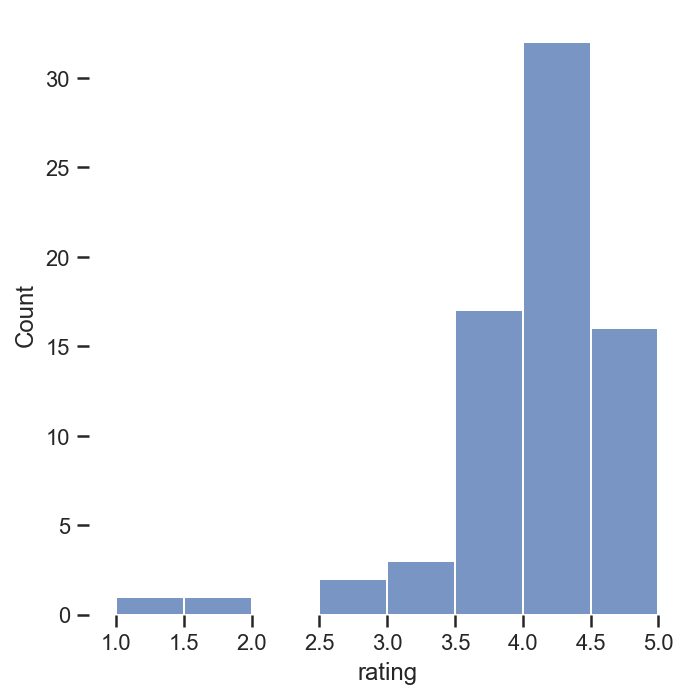

In [593]:
sns.displot(df2['rating'],binwidth=0.5)
sns.despine(bottom=True,left=True)

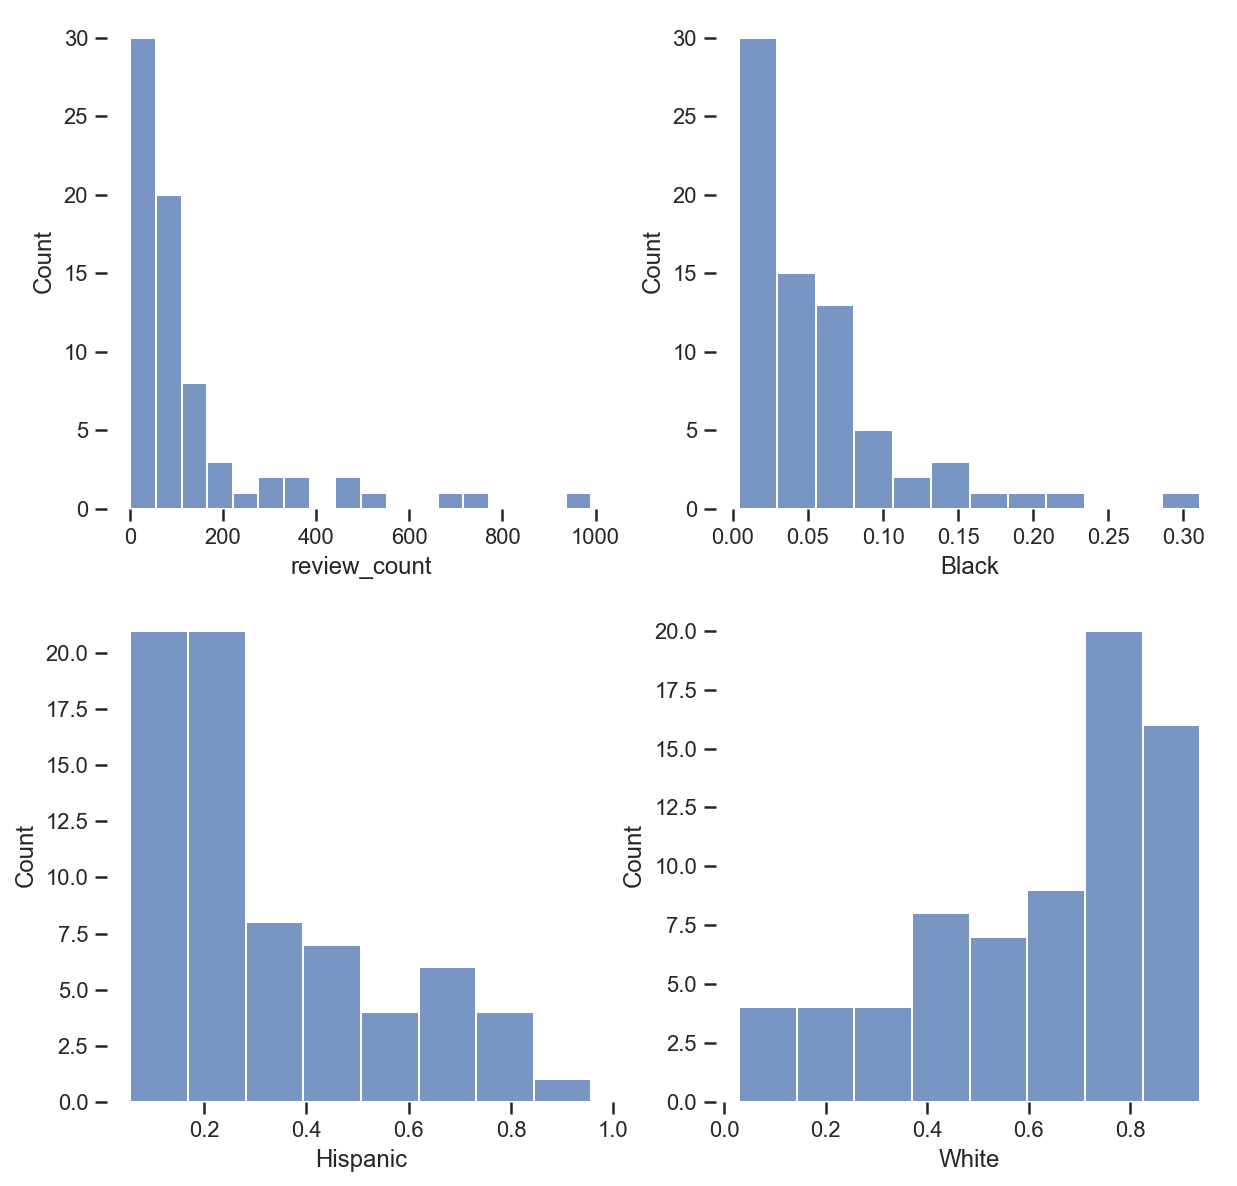

In [594]:
_, axes = plt.subplots(2, 2, figsize=(10,10))

sns.histplot(df2['review_count'],ax=axes[0,0])
sns.histplot(df2['Black'], ax=axes[0,1])
sns.histplot(df2['Hispanic'],ax=axes[1,0])
sns.histplot(df2['White'],ax=axes[1,1])

sns.despine(bottom=True,left=True)

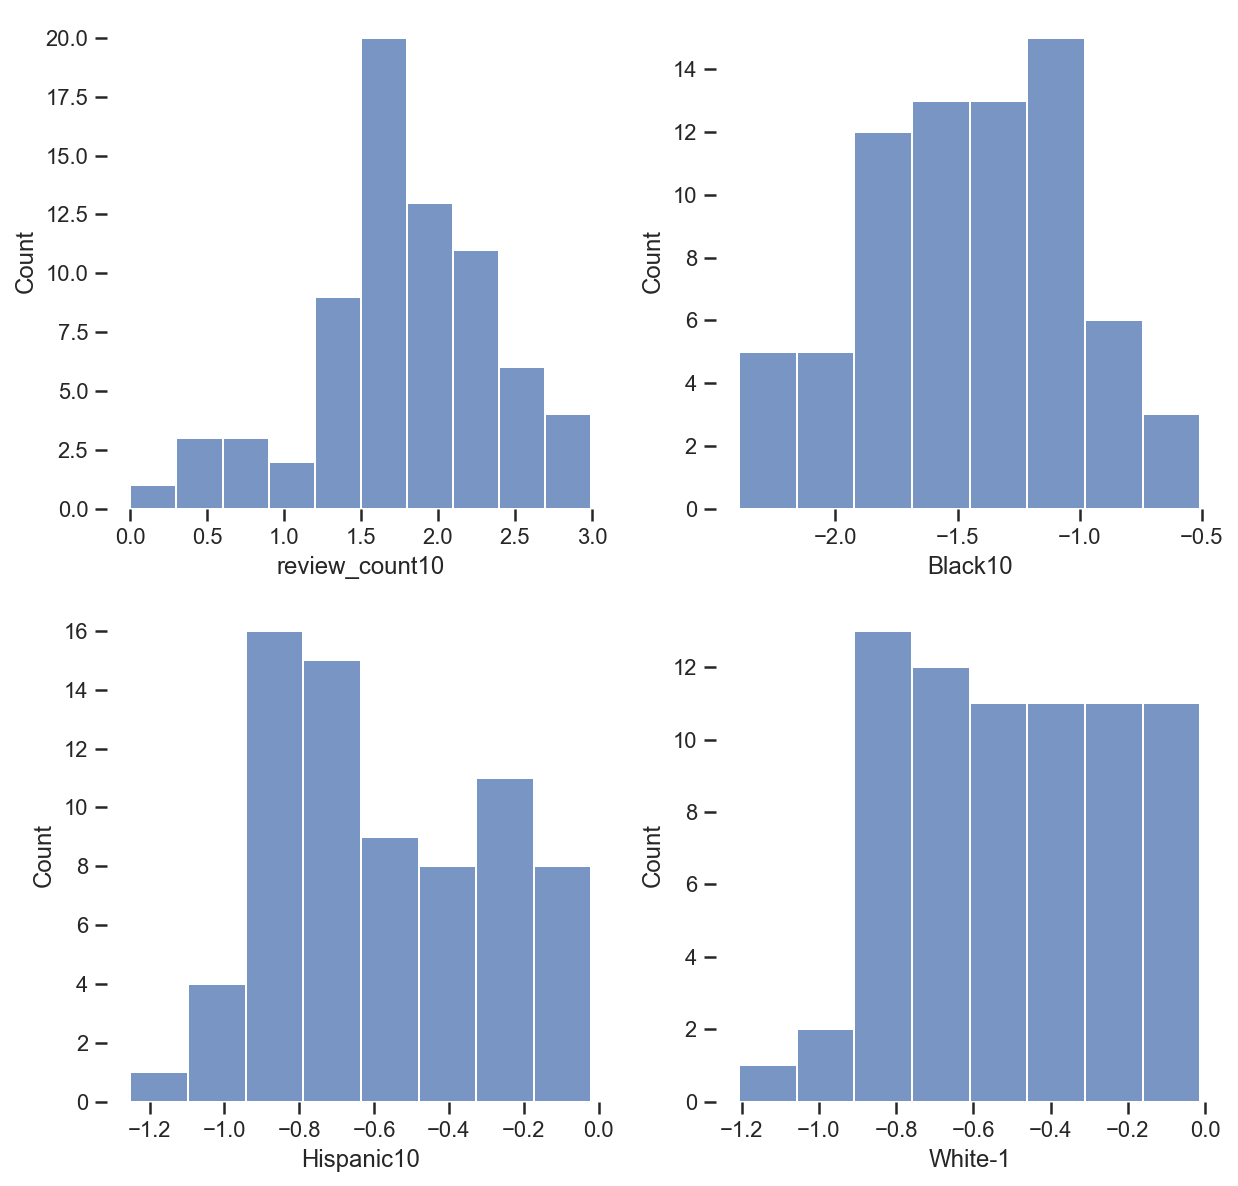

In [620]:
# Value transformation
df2['review_count10'] = np.log10(df2['review_count'])
df2['Black10'] = np.log10(df2['Black'])
df2['Hispanic10'] = np.log10(df2['Hispanic'])
#df2['White1/3'] = np.log(df2['White'])
df2['White-1'] = np.log10(df2['White'].apply(lambda x: 1-x))

# See distributions of transformed data
_, axes = plt.subplots(2,2, figsize=(10,10))

sns.histplot(df2['review_count10'], ax=axes[0,0])
sns.histplot(df2['Black10'], ax=axes[0,1])
sns.histplot(df2['Hispanic10'], ax=axes[1,0])
#sns.histplot(df2['White1/3'], ax=axes[1,1])
sns.histplot(df2['White-1'], ax=axes[1,1])

sns.despine(left=True,bottom=True)

In [621]:
h_rev2 = df2['review_count10'].values
h_blk = df2['Black10'].values
h_hisp = df2['Hispanic10'].values
h_white = df2['White-1'].values

st_rev2, p_rev2 = stats.normaltest(h_rev2)
st_blk, p_blk = stats.normaltest(h_blk)
st_hisp, p_hisp = stats.normaltest(h_hisp)
st_white, p_white = stats.normaltest(h_white)
print(p_rev2, p_blk,p_hisp,p_white)

0.056010435582462645 0.5580237111743576 0.040175678750165686 0.04239314490713347


array([[<AxesSubplot:xlabel='Black10', ylabel='Black10'>,
        <AxesSubplot:xlabel='White-1', ylabel='Black10'>,
        <AxesSubplot:xlabel='Hispanic10', ylabel='Black10'>],
       [<AxesSubplot:xlabel='Black10', ylabel='White-1'>,
        <AxesSubplot:xlabel='White-1', ylabel='White-1'>,
        <AxesSubplot:xlabel='Hispanic10', ylabel='White-1'>],
       [<AxesSubplot:xlabel='Black10', ylabel='Hispanic10'>,
        <AxesSubplot:xlabel='White-1', ylabel='Hispanic10'>,
        <AxesSubplot:xlabel='Hispanic10', ylabel='Hispanic10'>]],
      dtype=object)

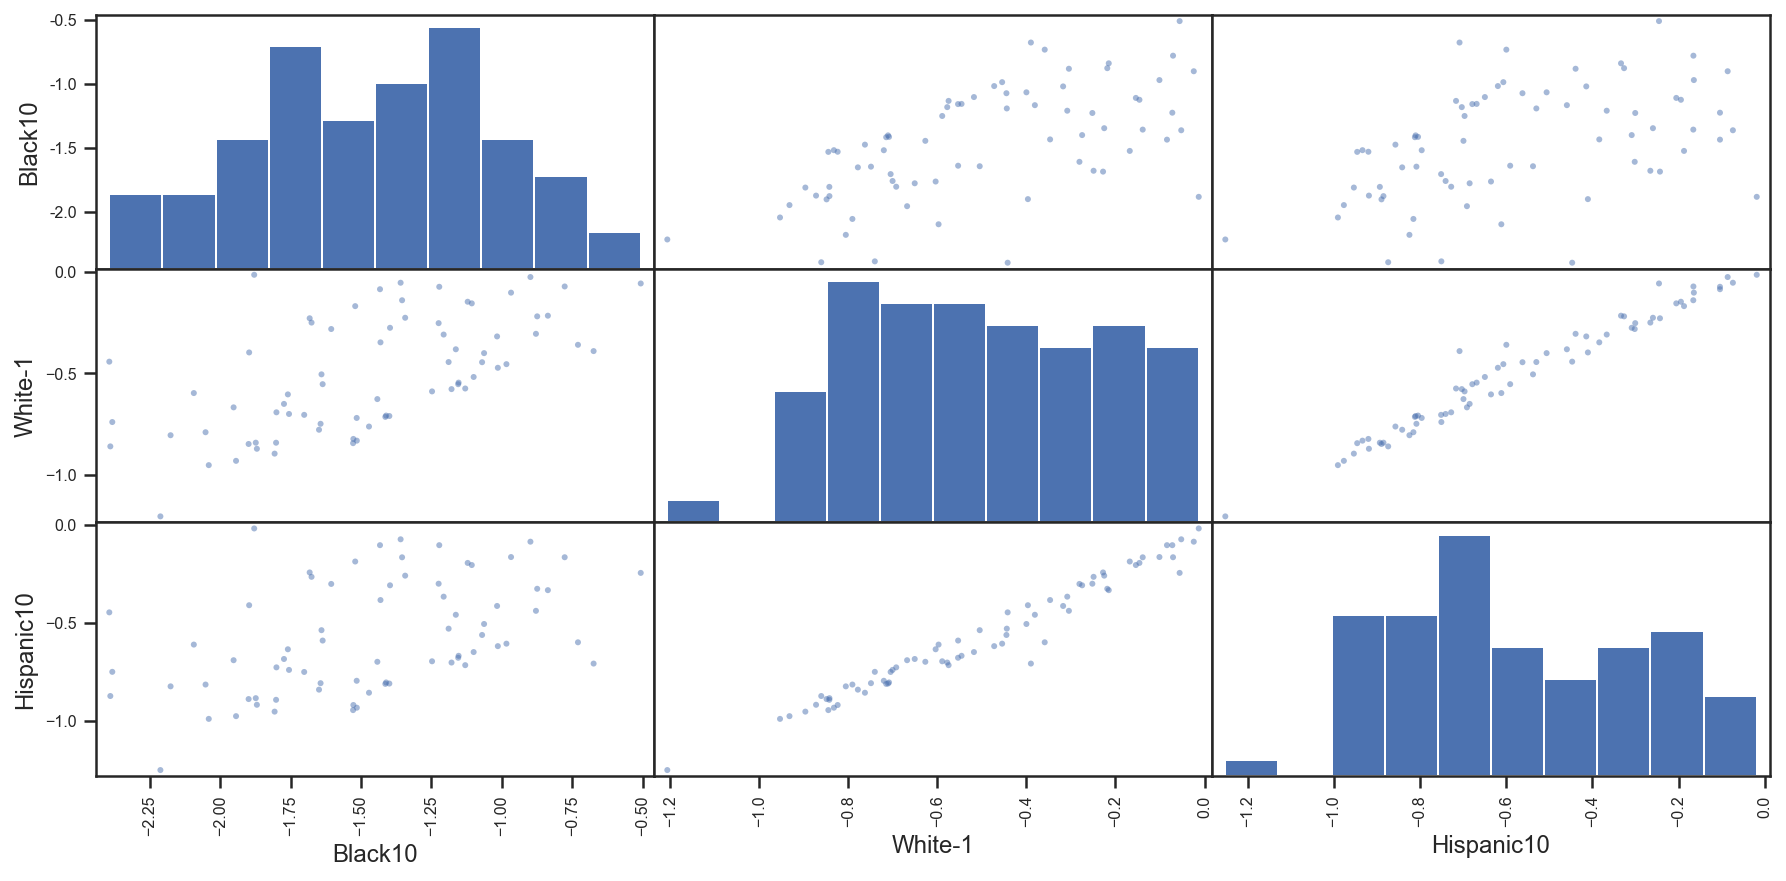

In [623]:
pd.plotting.scatter_matrix(df2[['Black10','White-1','Hispanic10']])

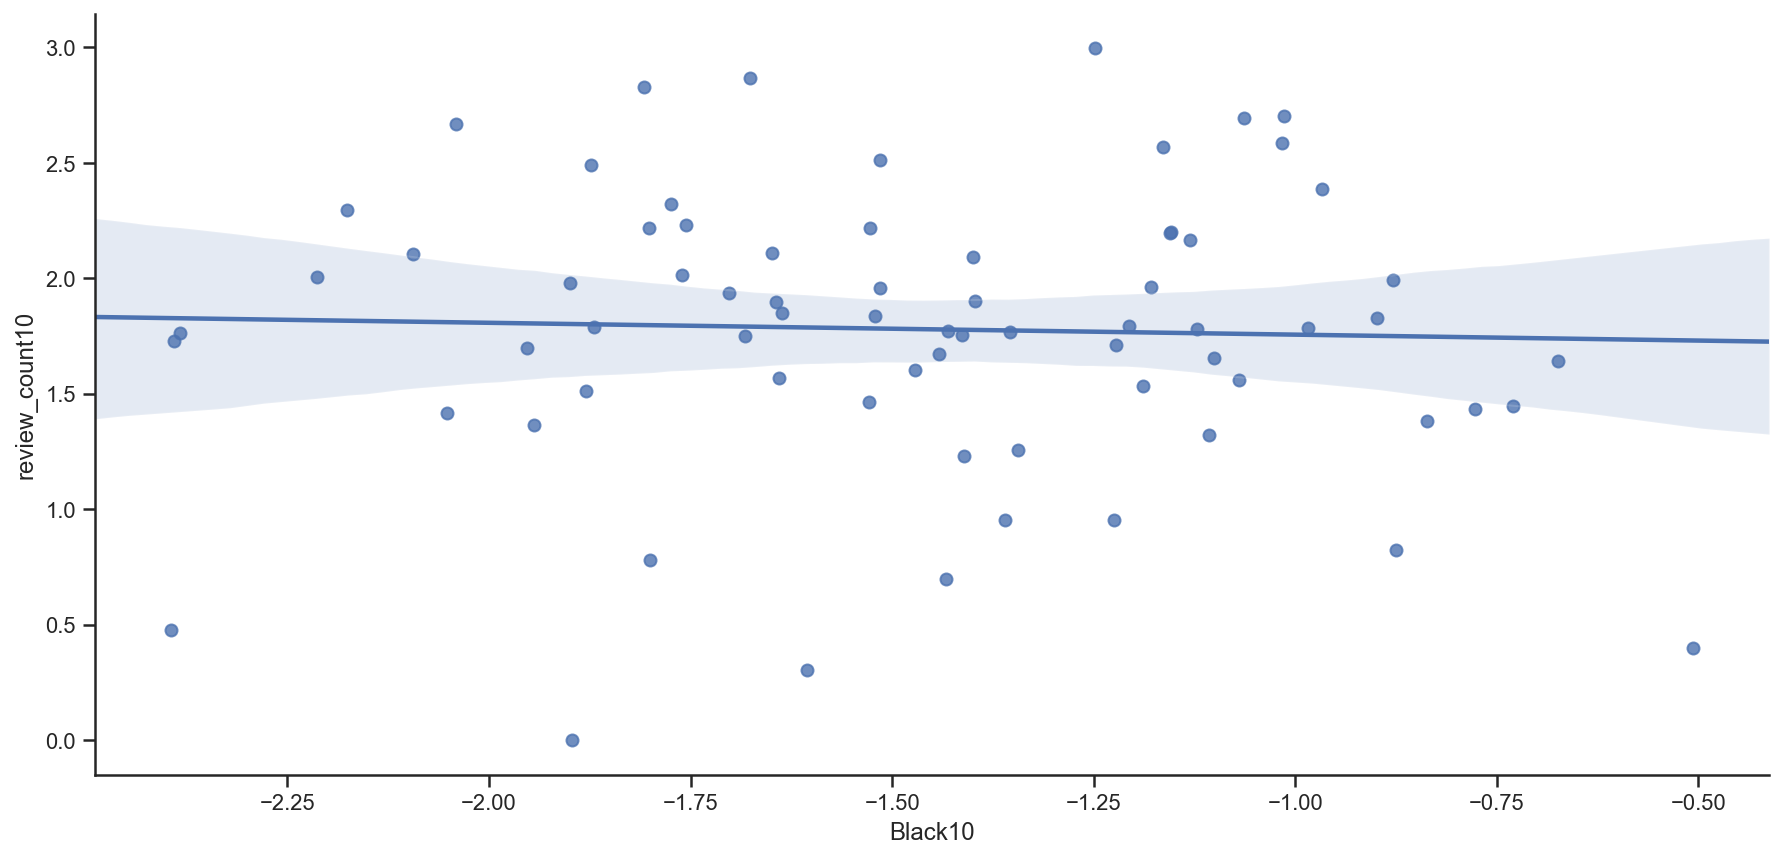

In [626]:
sns.regplot(x='Black10',y='review_count10',data=df2, truncate=False)
sns.despine()

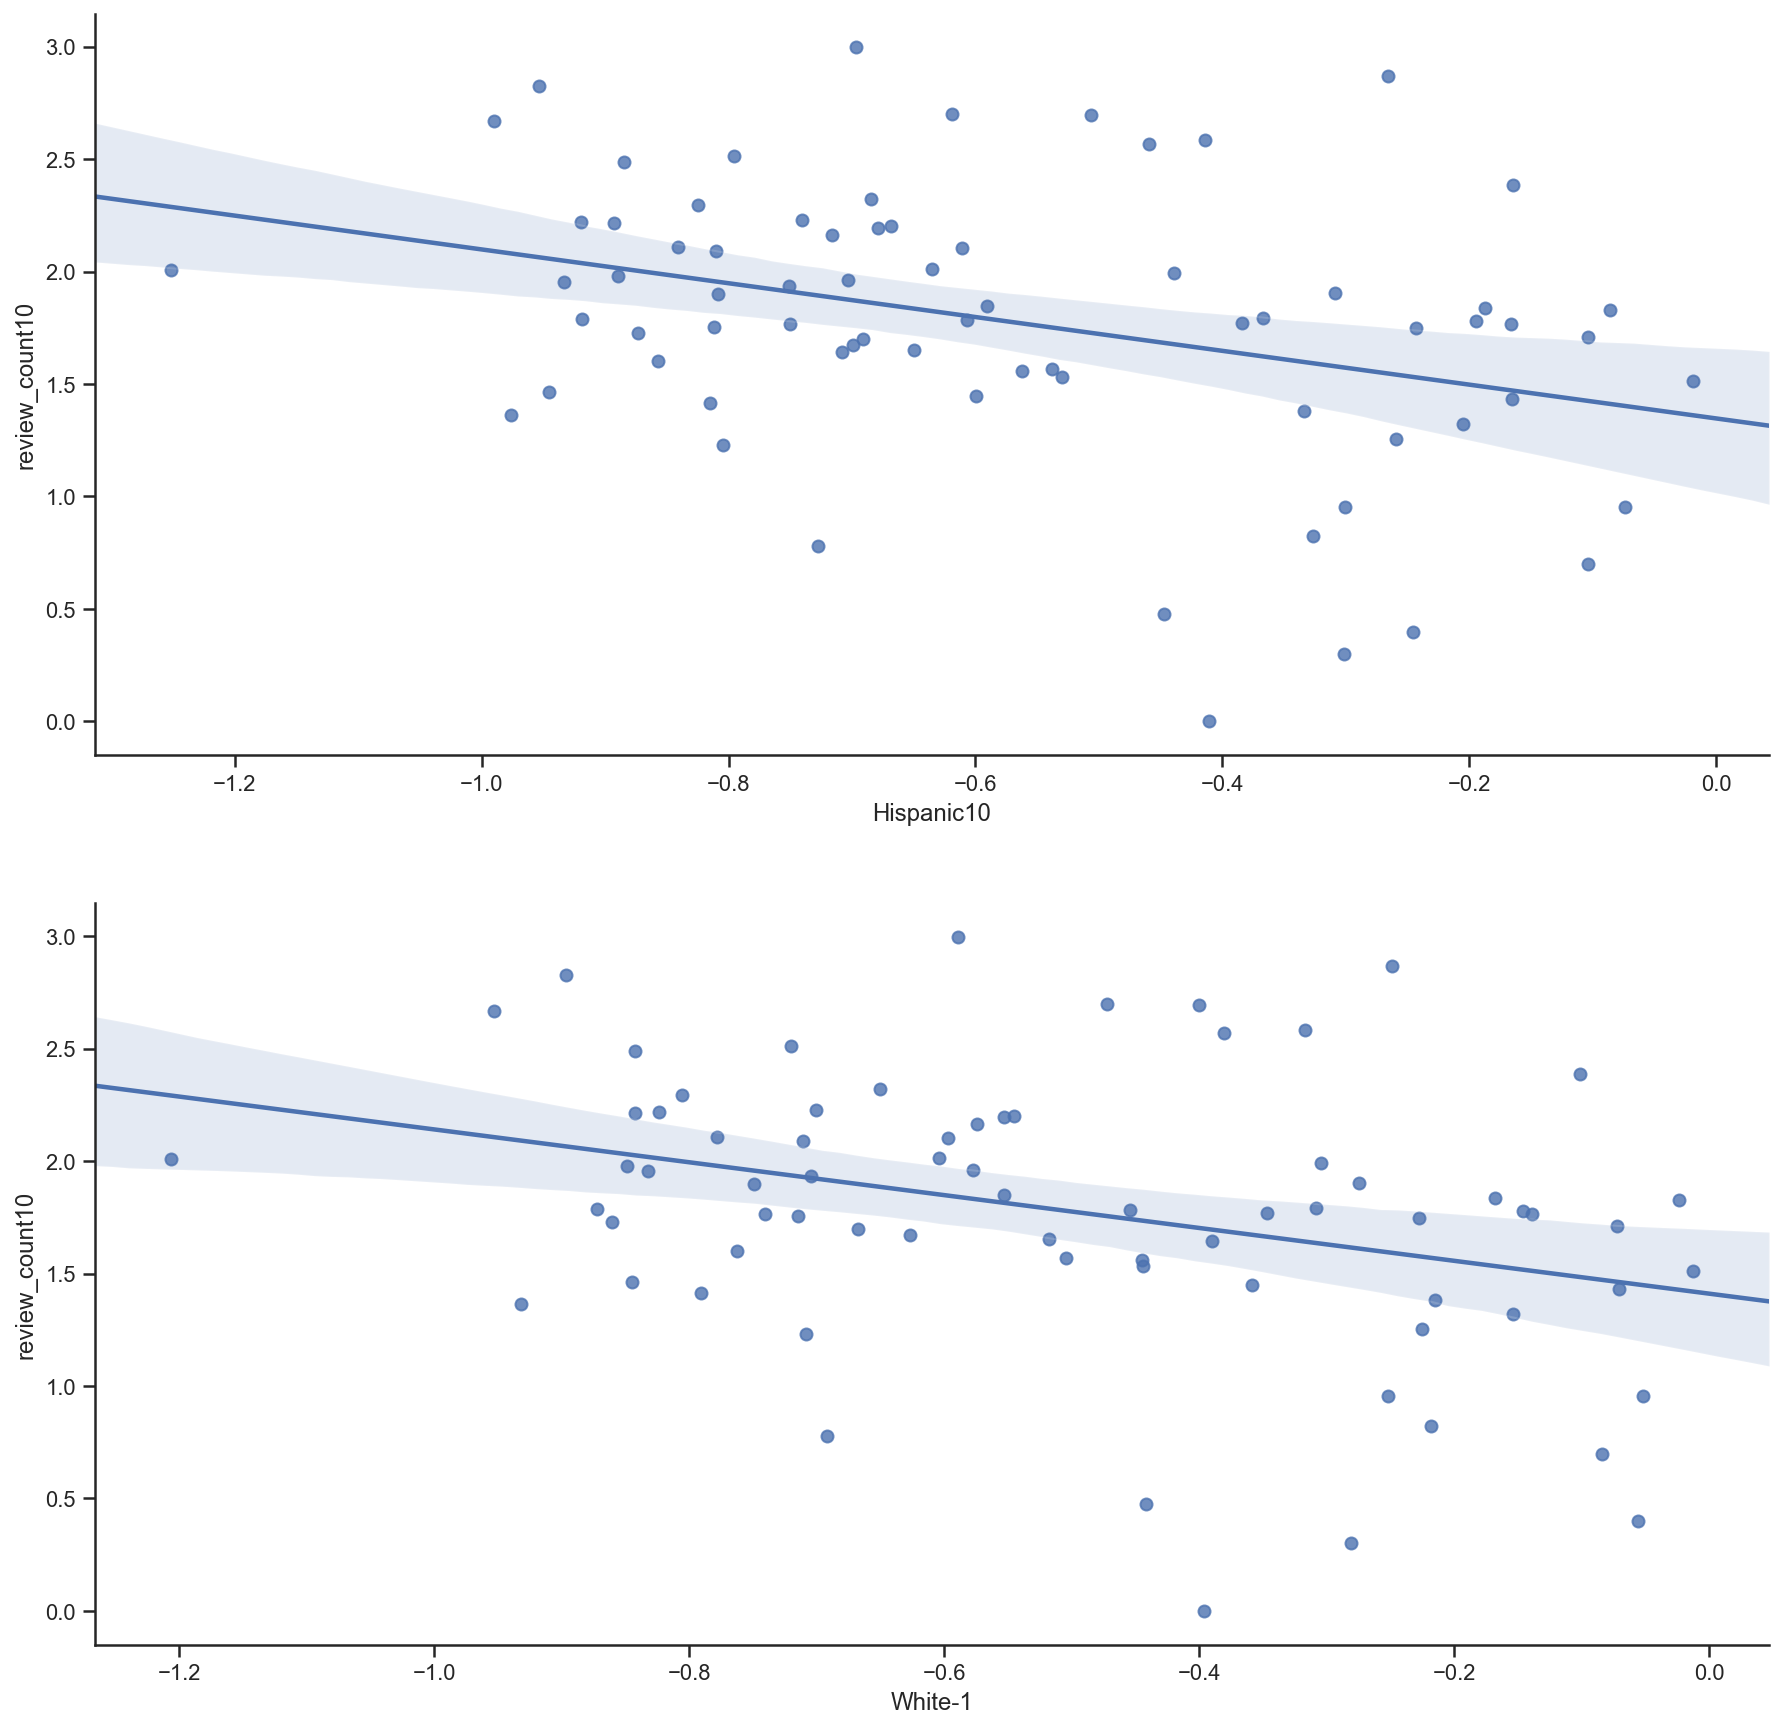

In [625]:
f, axes = plt.subplots(2,1, figsize=(15,15))

sns.regplot(x=df2['Hispanic10'],y=df2['review_count10'],truncate=False, ax=axes[0])
sns.regplot(x=df2['White-1'],y=df2['review_count10'], truncate=False, ax=axes[1])
sns.despine(f)